# RAG Agent

#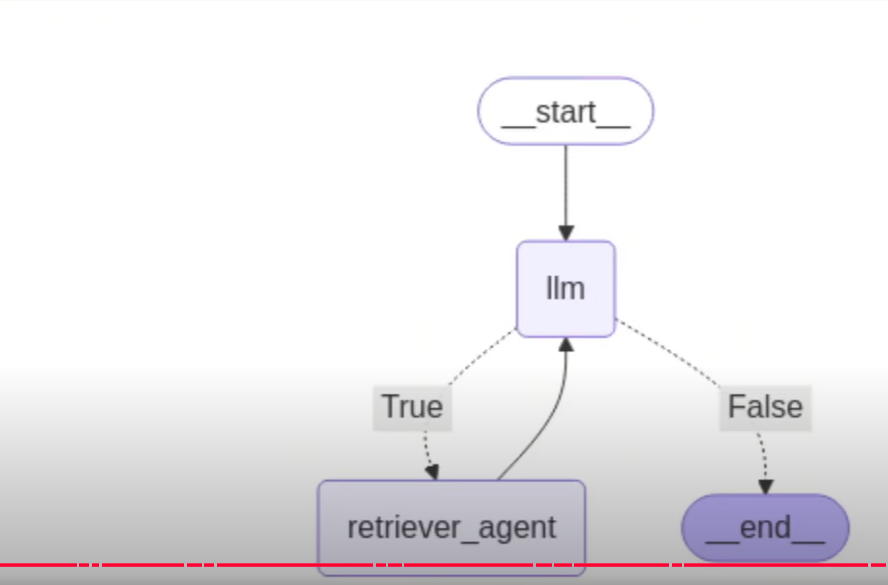

In [8]:
from dotenv import load_dotenv
import os
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool

In [16]:
#pip install langchain-chroma
!pip install pypdf


In [9]:
load_dotenv()

True

In [10]:
llm=ChatOpenAI(model="gpt-4o", temperature = 0) # I want to minimize hallucination - temperature = 0 makes the model output more deterministic

# Our Embedding Model - has to also be compatible with the LLM
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
)

pdf_path = "Stock_Market_Performance_2024.pdf"

In [17]:
# Safety measure I have put for debugging purposes :)
if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"PDF file not found: {pdf_path}")

pdf_loader = PyPDFLoader(pdf_path) # This loads the PDF

# Checks if the PDF is there
try:
    pages = pdf_loader.load()
    print(f"PDF has been loaded and has {len(pages)} pages")
except Exception as e:
    print(f"Error loading PDF: {e}")
    raise

PDF has been loaded and has 9 pages


In [18]:
# Chunking Process
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)



In [19]:
pages_split = text_splitter.split_documents(pages) # We now apply this to our pages

In [20]:
persist_directory = r"D:\HopeAI\LangGraph\AIAgent-LangGraph\Agents"
collection_name = "stock_market"

In [21]:
# If our collection does not exist in the directory, we create using the os command
if not os.path.exists(persist_directory):
    os.makedirs(persist_directory)

In [22]:
try:
    # Here, we actually create the chroma database using our embeddigns model
    vectorstore = Chroma.from_documents(
        documents=pages_split,
        embedding=embeddings,
        persist_directory=persist_directory,
        collection_name=collection_name
    )
    print(f"Created ChromaDB vector store!")
    
except Exception as e:
    print(f"Error setting up ChromaDB: {str(e)}")
    raise

Created ChromaDB vector store!


In [23]:
# Now we create our retriever 
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5} # K is the amount of chunks to return
)

In [24]:
@tool
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns the information from the Stock Market Performance 2024 document.
    """

    docs = retriever.invoke(query)

    if not docs:
        return "I found no relevant information in the Stock Market Performance 2024 document."
    
    results = []
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}:\n{doc.page_content}")
    
    return "\n\n".join(results)

In [25]:
tools = [retriever_tool]

llm = llm.bind_tools(tools)


In [26]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [27]:
def should_continue(state: AgentState):
    """Check if the last message contains tool calls."""
    result = state['messages'][-1]
    return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0


system_prompt = """
You are an intelligent AI assistant who answers questions about Stock Market Performance in 2024 based on the PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the stock market performance data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""


tools_dict = {our_tool.name: our_tool for our_tool in tools} # Creating a dictionary of our tools


In [28]:
# LLM Agent
def call_llm(state: AgentState) -> AgentState:
    """Function to call the LLM with the current state."""
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm.invoke(messages)
    return {'messages': [message]}

In [29]:
# Retriever Agent
def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""

    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")
        
        if not t['name'] in tools_dict: # Checks if a valid tool is present
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."
        
        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")
            

        # Appends the Tool Message
        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}



In [32]:
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_node("retriever_agent", take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "retriever_agent", False: END}
)
graph.add_edge("retriever_agent", "llm")
graph.set_entry_point("llm")

rag_agent = graph.compile()




In [33]:
def running_agent():
    print("\n=== RAG AGENT===")
    
    while True:
        user_input = input("\nWhat is your question: ")
        if user_input.lower() in ['exit', 'quit']:
            break
            
        messages = [HumanMessage(content=user_input)] # converts back to a HumanMessage type

        result = rag_agent.invoke({"messages": messages})
        
        print("\n=== ANSWER ===")
        print(result['messages'][-1].content)

In [36]:
running_agent

<function __main__.running_agent()>

In [ ]:
running_agent()


=== RAG AGENT===



What is your question:  what is my name?



=== ANSWER ===
I'm sorry, but I don't have access to personal data about individuals unless it has been shared with me in the course of our conversation. Therefore, I don't know your name. If you'd like, you can tell me your name!



What is your question:  Apple performance in 2024


Calling Tool: retriever_tool with query: Apple stock performance in 2024
Result length: 4874
Tools Execution Complete. Back to the model!

=== ANSWER ===
In 2024, Apple's stock experienced an impressive performance, climbing approximately 36% over the year. The share price reached new all-time highs, ending the year around $252 per share, up from about $185 at the start of the year. This rally increased Apple's market capitalization to nearly $4 trillion, reaffirming its status as the world's most valuable publicly traded company. The gains were driven by strong demand for Apple's products, successful launches of the iPhone 15 series, and growth in high-margin services. Additionally, Apple's expansion in emerging markets fueled investor optimism about future growth. Despite only moderate earnings increases, the stock's rapid appreciation led to an expansion in valuation, with Apple trading at about 40 times its trailing earnings by the end of 2024, well above its historical average P/E


What is your question:  Alphabet (Google) (GOOGL) - 2024 Performance


Calling Tool: retriever_tool with query: Alphabet (Google) (GOOGL) 2024 performance
Result length: 4570
Tools Execution Complete. Back to the model!

=== ANSWER ===
In 2024, Alphabet Inc., the parent company of Google, experienced a robust performance. The company's stock price rose by nearly 40% over the year, closing around $189 per share, which was close to record highs for the company. This increase in stock price added approximately $600 billion in market value, pushing Alphabet's market capitalization above $2 trillion by December 2024.

The strong performance was driven by Alphabet's core strength in digital advertising, which remained a major revenue driver, and its advancements in artificial intelligence. The company introduced its Gemini 2.0 AI model and made breakthroughs in quantum computing chips, which reassured investors about Google's leadership in technology innovation. Additionally, Google's cloud computing division continued to grow, contributing to the overall posit